In [2]:
# This notebook illustrates handling the September 2024 Demo of the 18-month epi evaluation scenario 2 question 9

# Import funman related code
import os
from funman import MODE_ODEINT, MODE_SMT, Interval, LinearConstraint
from funman.model.petrinet import GeneratedPetriNetModel

import json
import pandas as pd
import logging
import matplotlib.pyplot as plt
from helpers import run, get_model, setup_common, get_request, report
from funman import to_sympy
from funman.model.generated_models.petrinet import Initial
from typing import Dict
from funman import GeneratedPetriNetModel
from difflib import SequenceMatcher
from functools import reduce
from typing import Dict, List, Optional
from funman.model.generated_models.petrinet import Model1, Parameter, Rate, State,Transition, Properties, Model, Semantics, OdeSemantics, Initial
from funman.model.petrinet import GeneratedPetriNetModel, PetrinetModel
from sympy import Symbol

RESOURCES = "../../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-09")
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "sir_request1.json")

models = {
    "sir": os.path.join(
    EXAMPLE_DIR, "sir.json"),
}

requests = {
    "sir": REQUEST_PATH,
    "sir_stratified": os.path.join(EXAMPLE_DIR, "sir_stratified_request.json"),
    "sir_bounded_stratified": os.path.join(EXAMPLE_DIR, "sir_stratified_request.json"),
    "sir_bounded": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json"),
    "sir_bounded_manual": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json"),
    "sir_abstract_stratified_bounded": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json")
}

request_params = {}
request_results = {}

In [3]:
# Constants for the scenario

MAX_TIME=100
STEP_SIZE=10
MODE=MODE_ODEINT
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))

1 points
                                     beta  gamma    beta_1    beta_2  \
sir                              0.000315    0.1       NaN       NaN   
sir_stratified                        NaN    0.1  0.000314  0.000326   
sir_abstract_stratified_bounded       NaN    NaN       NaN       NaN   

                                  beta_lb  gamma_lb   beta_ub  gamma_ub  
sir                                   NaN       NaN       NaN       NaN  
sir_stratified                        NaN       NaN       NaN       NaN  
sir_abstract_stratified_bounded  0.000314       0.1  0.000316       0.1  


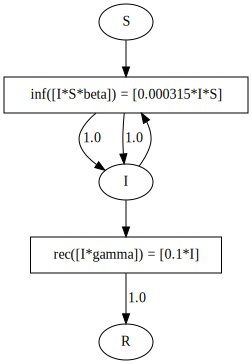

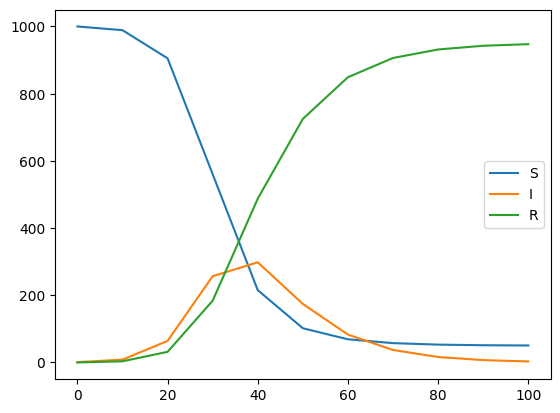

In [18]:
# 1) Process Base Model
model_str = "sir"
(base_model, request) = get_model(models[model_str])

funman_request = get_request(requests[model_str])
setup_common(funman_request, timepoints, debug=True, mode=MODE, synthesize=False,dreal_precision=1)
results = run(funman_request, model_str, models)
report(results, model_str, base_model._state_var_names() + base_model._observable_names(), request_results, request_params)
base_model.to_dot()

In [19]:
results.timing.total_time

datetime.timedelta(microseconds=210209)

In [77]:
# 2) Stratify and Analyze the Base model with vaccination status


NUM_STRATA=100


# 2) Analyze Stratified Base Model    
    
# Stratify the base model
stratified_model = base_model.stratify("S", [str(i+1) for i in range(0,NUM_STRATA)], strata_parameters=["beta"], strata_transitions=None, self_strata_transition=False)

# # Modify the beta_1 and beta_2 parameters
# parameters = stratified_model.petrinet.semantics.ode.parameters
# beta_1 = next(p for p in parameters if p.id == "beta_1")
# beta_2 = next(p for p in parameters if p.id == "beta_2")
# beta_1_width = (beta_1.distribution.parameters["maximum"] - beta_1.distribution.parameters["minimum"]) 
# beta_1.value = beta_1.distribution.parameters["minimum"] + 0.45 * beta_1_width
# beta_2_width = (beta_2.distribution.parameters["maximum"] - beta_2.distribution.parameters["minimum"]) 
# beta_2.value = beta_2.distribution.parameters["minimum"] + 0.55 * beta_2_width                            

# # Save the stratified model
# stratified_model_str = f"{model_str}_stratified"
# stratified_model_path = os.path.join(EXAMPLE_DIR, stratified_model_str+".json")
# models[stratified_model_str] = stratified_model_path
# with open(stratified_model_path, "w") as f:
#     f.write(stratified_model.petrinet.model_dump_json())


# # Analyze the stratified model
# stratified_request = get_request(requests[stratified_model_str])

# # Modify request parameters
# request_parameters = stratified_request.parameters
# req_beta_1 = next(p for p in request_parameters if p.name == "beta_1")
# req_beta_2 = next(p for p in request_parameters if p.name == "beta_2")
# req_beta_1.interval = Interval(lb=beta_1.value, ub = beta_1.value, closed_upper_bound = True)
# req_beta_2.interval = Interval(lb=beta_2.value, ub = beta_2.value, closed_upper_bound = True)

# # stratified_request = FunmanWorkRequest()
# setup_common(stratified_request, timepoints, debug=True, mode=MODE, synthesize=False,dreal_precision=1)
# results = run(stratified_request, stratified_model_str, models)
# report(results, stratified_model_str, stratified_model._state_var_names() + stratified_model._observable_names(), request_results, request_params)
# stratified_model.to_dot()

In [78]:
m = stratified_model

len(list(m.petrinet.model.states)) + len(list(m.petrinet.model.transitions))+ len(list(m.petrinet.semantics.ode.parameters))

304

In [10]:

results.timing.total_time

datetime.timedelta(seconds=5, microseconds=126689)

In [84]:
import datetime
stratified_runtime = {
    2: datetime.timedelta(microseconds=254395),
    25: datetime.timedelta(seconds=1, microseconds=889263),
    50: datetime.timedelta(seconds=5, microseconds=126689),
    100: datetime.timedelta(seconds=16, microseconds=737672)
}
base_runtime = datetime.timedelta(microseconds=210209)
abstracted_runtime = datetime.timedelta(microseconds=343941)

model_elements = {
    "base": 7,
    "abstracted": 18,
    "stratified_2": 10,
    "stratified_25": 79,
    "stratified_50": 154,
    "stratified_100": 304,

}

runtime = pd.Series({
    **{"base": base_runtime, "abstracted": abstracted_runtime},
    **{f"stratified_{k}": v for k, v in stratified_runtime.items()}
    })
elements = pd.Series(model_elements)

from dateutil.relativedelta import relativedelta

def get_duration(row):
    return f"{row.seconds}.{row.microseconds}"

# runtime.apply(get_duration).to_frame().to_csv("stratification_sir_timing.csv")
",".join([str(s) for s in elements.values])
    


'7,18,10,79,154,304'

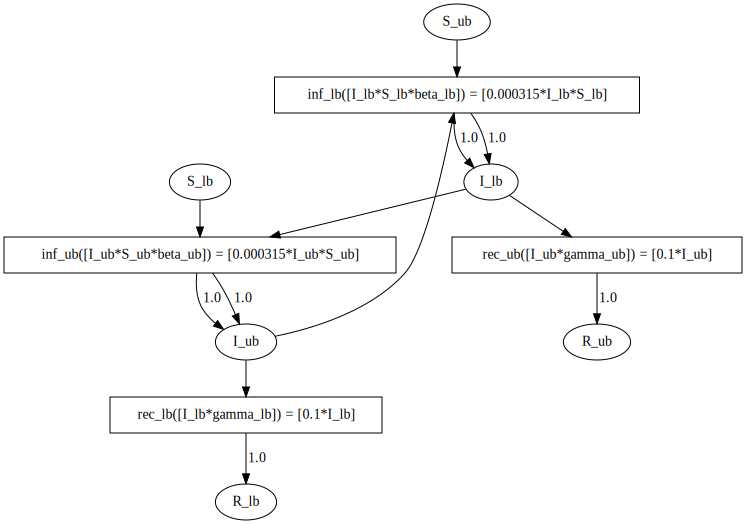

In [5]:

    
bounded_model: GeneratedPetriNetModel = base_model.formulate_bounds()
bounded_model_str = f"{model_str}_bounded"
bounded_model_path = os.path.join(EXAMPLE_DIR, bounded_model_str+".json")
models[bounded_model_str] = bounded_model_path
with open(bounded_model_path, "w") as f:
    f.write(bounded_model.petrinet.model_dump_json())

bounded_model.to_dot()

2024-10-08 22:28:52,762 - funman.representation.interval - WARNING - [0.00032, 0.00032) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-10-08 22:28:52,766 - funman.representation.interval - WARNING - [0.10000, 0.10000) has equal lower and upper bounds, so assuming the upper bound is closed.  (I.e., [lb, ub) is actually [lb, ub])
2024-10-08 22:28:52,792 - funman.server.worker - ERROR - Internal Server Error (bf55a8ca-b669-4694-b0f5-2bdac5069143):
Traceback (most recent call last):
  File "/root/funman/src/funman/server/worker.py", line 231, in _run
    scenario = work.to_scenario()
  File "/root/funman/src/funman/server/query.py", line 150, in to_scenario
    return ConsistencyScenario(
  File "/root/funman/src/funman/scenario/scenario.py", line 89, in __init__
    super().__init__(**kwargs)
  File "/root/funman_venv/lib/python3.8/site-packages/pydantic/main.py", line 212, in __init__
    validated_self = self.__pydant

0 points


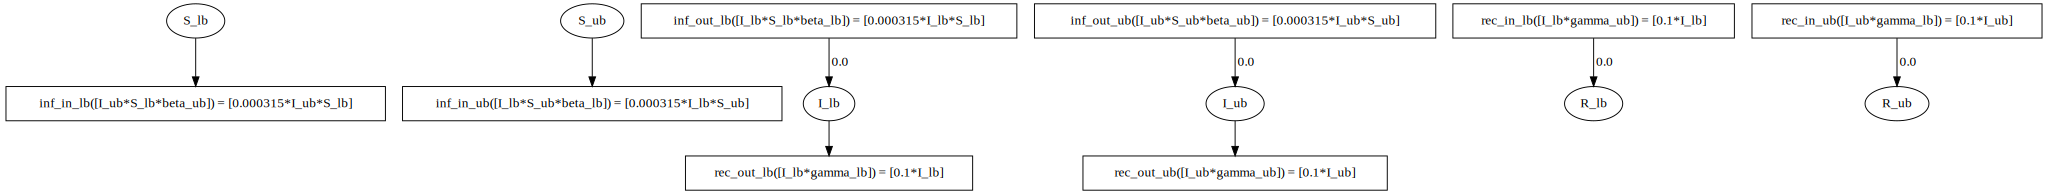

In [6]:
# 3) Analyze Bounded Base Model

# Use temporary manual encoding with the following block
bounded_model_str = f"{model_str}_bounded"
bounded_model_path = os.path.join(EXAMPLE_DIR, bounded_model_str+"_manual"+".json")
models[bounded_model_str] = bounded_model_path
with open(bounded_model_path, "r") as f:
   bounded_model  = GeneratedPetriNetModel(petrinet=Model.model_validate(json.load(f)))

bounded_request = get_request(requests[bounded_model_str])

# Modify the beta_1 and beta_2 parameters
parameters = bounded_model.petrinet.semantics.ode.parameters
beta_1 = next(p for p in parameters if p.id == "beta_lb")
beta_2 = next(p for p in parameters if p.id == "beta_ub")
beta_1.value = 0.000315
beta_2.value = 0.000315

with open(stratified_model_path, "w") as f:
    f.write(bounded_model.petrinet.model_dump_json())

setup_common(bounded_request, timepoints, debug=True, mode=MODE, synthesize=False,dreal_precision=1)
results = run(bounded_request, bounded_model_str, models)
report(results, bounded_model_str, bounded_model._state_var_names() + bounded_model._observable_names(), request_results, request_params)
bounded_model.to_dot()

2024-10-08 22:28:55,042 - funman.server.worker - ERROR - Internal Server Error (648de896-4f90-4ce3-8f07-775a131d85ee):
Traceback (most recent call last):
  File "/root/funman/src/funman/server/worker.py", line 231, in _run
    scenario = work.to_scenario()
  File "/root/funman/src/funman/server/query.py", line 150, in to_scenario
    return ConsistencyScenario(
  File "/root/funman/src/funman/scenario/scenario.py", line 89, in __init__
    super().__init__(**kwargs)
  File "/root/funman_venv/lib/python3.8/site-packages/pydantic/main.py", line 212, in __init__
    validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)
pydantic_core._pydantic_core.ValidationError: 4 validation errors for ConsistencyScenario
parameters.0
  Input should be a valid dictionary or instance of Parameter [type=model_type, input_value=beta_1[0.00026000000000000003, 0.00038), input_type=ModelParameter]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type
p

0 points


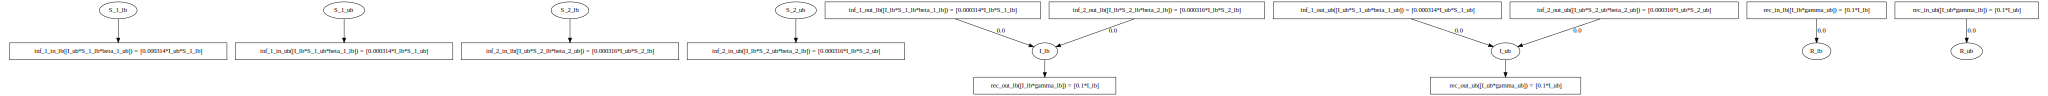

In [7]:
# 3) Bound the stratified model

# Use temporary manual encoding with the following block
bounded_stratified_model_str = f"{model_str}_bounded_stratified"
bounded_stratified_model_path = os.path.join(EXAMPLE_DIR, bounded_stratified_model_str+"_manual"+".json")
models[bounded_stratified_model_str] = bounded_stratified_model_path
with open(bounded_stratified_model_path, "r") as f:
    bounded_stratified_model = GeneratedPetriNetModel(petrinet=Model.model_validate(json.load(f)))


# bounded_stratified_model: GeneratedPetriNetModel = formulate_bounds(stratified_model)
# bounded_stratified_model_str = f"{model_str}_bounded_stratified"
# bounded_stratified_model_path = os.path.join(EXAMPLE_DIR, bounded_stratified_model_str+".json")
# models[bounded_stratified_model_str] = bounded_stratified_model_path
# with open(bounded_stratified_model_path, "w") as f:
    # f.write(bounded_stratified_model.petrinet.model_dump_json())
    
bounded_stratified_request = get_request(requests[bounded_stratified_model_str])
setup_common(bounded_stratified_request, timepoints, debug=True, mode=MODE, synthesize=False,dreal_precision=1)
results = run(bounded_stratified_request, bounded_stratified_model_str, models)
report(results, bounded_stratified_model_str, bounded_stratified_model._state_var_names() + bounded_stratified_model._observable_names(), request_results, request_params)    
    
# print(results.dataframe(results.points()))
bounded_stratified_model.to_dot()

In [8]:
abstract_stratified_model: GeneratedPetriNetModel = abstract(stratified_model, {"S_1": "S", "S_2": "S"}) #formulate_bounds(abstract(stratified_model, {"I_u": "I", "I_v": "I"}))
# mb.to_dot()

# stratified_model = stratify(base_model, "I", ["u", "v"], strata_parameter="beta", strata_transitions=["t1"], self_strata_transition=True)
abstract_stratified_model_str = f"{model_str}_abstract_stratified"

abstract_stratified_model_path = os.path.join(EXAMPLE_DIR, abstract_stratified_model_str+".json")
models[abstract_stratified_model_str] = abstract_stratified_model_path
with open(abstract_stratified_model_path, "w") as f:
    f.write(abstract_stratified_model.petrinet.model_dump_json())


abstract_stratified_model.to_dot()

NameError: name 'abstract' is not defined

In [ ]:
# Bound the abstract stratified model
# abstract_stratified_bounded_model: GeneratedPetriNetModel = formulate_bounds(abstract_stratified_model)
# abstract_stratified_bounded_model_str = f"{model_str}_abstract_stratified_bounded"
# abstract_stratified_bounded_model_path = os.path.join(EXAMPLE_DIR, abstract_stratified_bounded_model_str+".json")
# models[abstract_stratified_bounded_model_str] = abstract_stratified_bounded_model_path
# with open(abstract_stratified_bounded_model_path, "w") as f:
#     f.write(abstract_stratified_bounded_model.petrinet.model_dump_json())
# abstract_stratified_bounded_model.to_dot()

1 points
                                     beta  gamma    beta_1    beta_2   beta_3  \
sir                              0.000315    0.1       NaN       NaN      NaN   
sir_stratified                        NaN    0.1  0.000314  0.000326  0.00026   
sir_abstract_stratified_bounded       NaN    NaN       NaN       NaN      NaN   

                                  beta_4   beta_5   beta_6   beta_7   beta_8  \
sir                                  NaN      NaN      NaN      NaN      NaN   
sir_stratified                   0.00026  0.00026  0.00026  0.00026  0.00026   
sir_abstract_stratified_bounded      NaN      NaN      NaN      NaN      NaN   

                                 ...  beta_20  beta_21  beta_22  beta_23  \
sir                              ...      NaN      NaN      NaN      NaN   
sir_stratified                   ...  0.00026  0.00026  0.00026  0.00026   
sir_abstract_stratified_bounded  ...      NaN      NaN      NaN      NaN   

                                 beta_24

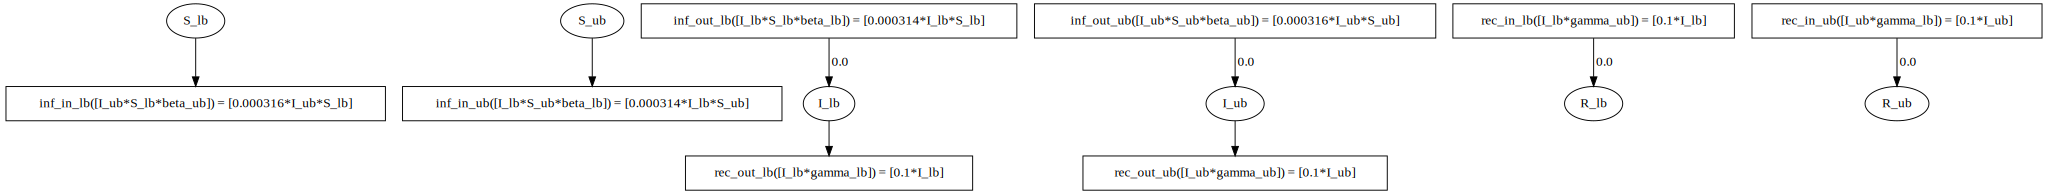

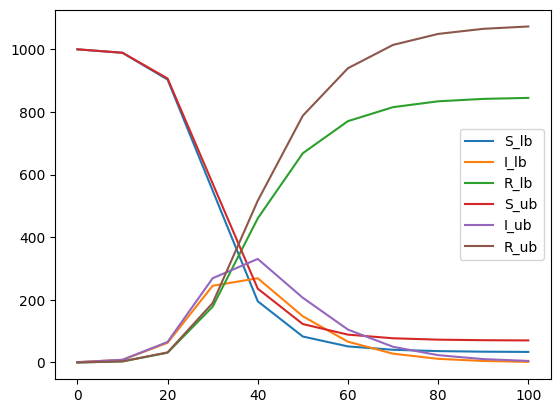

In [13]:
# 4) Analyze Abstract Stratified Bounded Base Model
# Use temporary manual encoding with the following block
abstract_stratified_bounded_model_str = f"{model_str}_abstract_stratified_bounded"
abstract_stratified_bounded_model_path = os.path.join(EXAMPLE_DIR, abstract_stratified_bounded_model_str+"_manual"+".json")
models[abstract_stratified_bounded_model_str] = abstract_stratified_bounded_model_path
with open(abstract_stratified_bounded_model_path, "r") as f:
    abstract_stratified_bounded_model = GeneratedPetriNetModel(petrinet=Model.model_validate(json.load(f)))
    



abstract_stratified_bounded_request = get_request(requests[abstract_stratified_bounded_model_str])

# old_timepoints = timepoints
# timepoints = [0.0, 1.0, 10.0]
setup_common(abstract_stratified_bounded_request, timepoints, debug=True, mode=MODE, synthesize=False,dreal_precision=1)
abs_results = run(abstract_stratified_bounded_request, abstract_stratified_bounded_model_str, models)
# timepoints = old_timepoints
report(abs_results, abstract_stratified_bounded_model_str, abstract_stratified_bounded_model._state_var_names() + abstract_stratified_bounded_model._observable_names(), request_results, request_params)
abstract_stratified_bounded_model.to_dot()


dS/dt = -SIB
d^2S/dt^2 = 

S_{t+\delta t} = S_t + dS/dt \delta t    
        = s_t - dS/dt d^2S/dt^2 \delta t

In [14]:
abs_results.timing.total_time

datetime.timedelta(microseconds=343941)